In [1]:
%cd /om/user/xboix/src/adversarial/Robustness

/om/user/xboix/src/adversarial/Robustness


In [2]:
experiment_name = "mnist"
results_dir = '/vast/robustness/' + experiment_name + '/'
import runs.config_experiments_mnist as run
experiment_list = run.config_experiments(results_dir, create_json=False)

336 config files created


In [3]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("poster")

import matplotlib.pyplot as plt
import pandas as pd
import pickle 

import numpy as np
import os


In [4]:
name_attacks = ["linf_pgd","l2_pgd", "linf_fgsm", "l2_fgm"]

In [5]:
# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:
    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

for kk in parameters.keys():
    print(kk)
    print(list(parameters[kk].keys()))

epsilon
[0.01, 0.05, 0.1, 0.25, 0.5, 1, 0.001, 0.0001, 1e-05, 100.0, 1000.0, 5]
backbone
['MLP', 'CNN', 'Madry', 'CNN+pgd', 'CNN+clipping']
initial_learning_rate
[0.1, 0.01, 0.001, 0.0001, 1e-05]
robust_training
[True, False]
epsilon_pgd_training
[0.1, 0.3, 0.5]


In [6]:
list_entries = []
for cv_epsilon in range(13):
        # Hash table of parameters
        parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
                      "robust_training": {}, "epsilon_pgd_training":{}}

        to_exclude = []
        experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
        for exp in experiment_list_tmp:

            for kk in parameters.keys():
                if exp[kk] in parameters[kk]:
                    parameters[kk][exp[kk]].append(int(exp["model_name"]))
                else:
                    parameters[kk][exp[kk]] = [int(exp["model_name"])]


        # For all methods, do cross-val and create an entry of the results
        backbones = ['CNN', 'CNN+pgd','Madry']
        robust_trainings = [True,False]

        for backbone in backbones:
            for robust_training in robust_trainings:
                
                if (backbone == 'Madry' and robust_training == True) or \
                    (backbone == 'CNN+clipping' and robust_training == False):
                    continue

                ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))

                #if backbone == 'MLP+pgd' and robust_training == True:
                #    continue

                if ids == []:
                    continue
                #print(ids)
                
                for attack in name_attacks:

                    # Cross-validation among learning rates and epsilons:
                    best_acc = -1.0
                    best_id = -1
                    for id in ids:
                        file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
                        if not os.path.isfile(file_name):
                            print("Missing!! " + file_name)
                            continue
                        with open(file_name, 'rb') as f:
                            tmp = pickle.load(f)

                        ave_acc = 0.0
                        for test_epsilon in list(tmp.keys())[cv_epsilon:cv_epsilon+1]:
                            ave_acc += tmp[test_epsilon]
                        acc = ave_acc / len(tmp.keys())
                        if acc>best_acc:
                            best_id = id
                            best_acc = acc

                    entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                            "backbone": experiment_list[best_id]['backbone'],
                            "robust_training": experiment_list[best_id]['robust_training'],
                            "epsilon": experiment_list[best_id]['epsilon'],
                            "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training']}

                    dataset = "test"
                    entry["attack"] = attack
                    entry["experiment_id"] = best_id

                    with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                        attack + '.pkl', 'rb') as f:
                        tmp = pickle.load(f)

                    for test_epsilon in list(tmp.keys())[cv_epsilon:cv_epsilon+1]:
                        entry["test_epsilon"] = test_epsilon
                        entry["accuracy"] =  100*tmp[test_epsilon]
                        list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 

In [8]:
df_results[df_results.backbone=='Madry']

,learning_rate,backbone,robust_training,epsilon,epsilon_pgd_training,attack,experiment_id,test_epsilon,accuracy
16,0.001,Madry,False,0.1,0.3,linf_pgd,95,0.0000,98.476562
17,0.001,Madry,False,0.1,0.3,l2_pgd,95,0.0000,98.320312
18,0.001,Madry,False,0.1,0.3,linf_fgsm,95,0.0000,98.593750
19,0.001,Madry,False,0.1,0.3,l2_fgm,95,0.0000,98.281250
36,0.001,Madry,False,0.1,0.3,linf_pgd,95,0.0002,98.476562
37,0.001,Madry,False,0.1,0.3,l2_pgd,95,0.0020,98.320312
38,0.001,Madry,False,0.1,0.3,linf_fgsm,95,0.0002,98.593750
39,0.001,Madry,False,0.1,0.3,l2_fgm,95,0.0020,98.242188
56,0.001,Madry,False,0.1,0.3,linf_pgd,95,0.0005,98.437500
57,0.001,Madry,False,0.1,0.3,l2_pgd,95,0.0050,98.320312


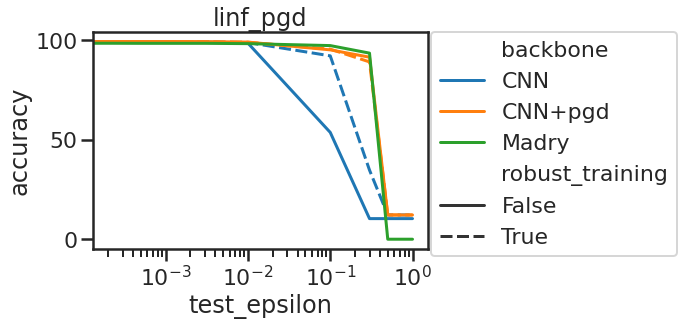

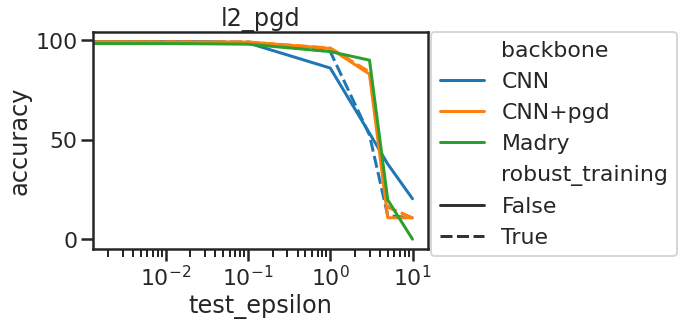

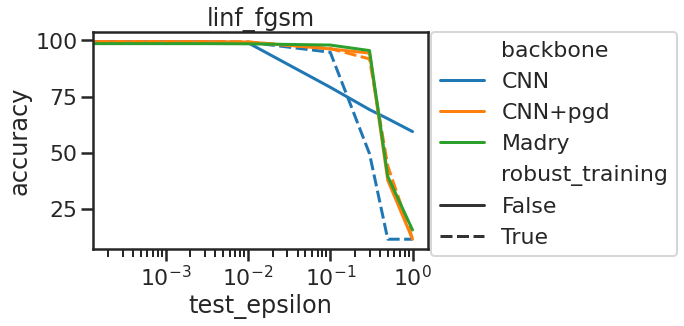

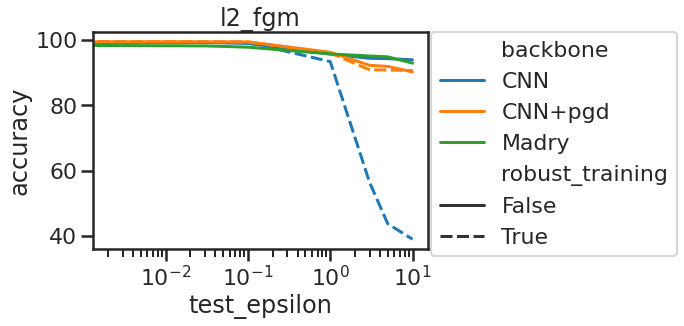

In [7]:
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df_results[(df_results.attack==attack)]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [17]:
list_entries = []

# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:

    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

# For all methods, do cross-val and create an entry of the results
backbones = ['CNN', 'CNN+pgd']
robust_trainings = [True,False]

for backbone in backbones:
    for robust_training in robust_trainings:
        
        if backbone == 'CNN+pgd':
            eps = parameters['epsilon_pgd_training'].keys()
        else:
            eps = parameters['epsilon'].keys()
            
        for ep in eps: #for each epsilon in training:
            
            if (backbone == 'Madry' and robust_training == True) or \
                (backbone == 'CNN+clipping' and robust_training == False):
                continue

            ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))

            if backbone == 'CNN+pgd':
                ids = list(set(ids) & set(parameters["epsilon_pgd_training"][ep]) )
            else:
                ids = list(set(ids) & set(parameters["epsilon"][ep]) )
            
            if ids == []:
                continue

            # Cross-validation among learning rates and epsilons:
            best_acc = 0.0
            best_id = -1
            for id in ids:
                file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + name_attacks[0] + '.pkl'
                if not os.path.isfile(file_name):
                    print("Missing!! " + file_name)
                    continue
                with open(file_name, 'rb') as f:
                    tmp = pickle.load(f)

                acc = tmp[0.0]
                if acc>best_acc:
                    best_id = id
                    best_acc = acc

            entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                    "backbone": experiment_list[best_id]['backbone'],
                    "robust_training": experiment_list[best_id]['robust_training'],
                    "epsilon": experiment_list[best_id]['epsilon'],
                    "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training']}

            dataset = "test"
            entry["attack"] = name_attacks[0]
            entry["experiment_id"] = best_id

            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                name_attacks[0] + '.pkl', 'rb') as f:
                tmp = pickle.load(f)


            entry["train_epsilon"] = ep
            entry["accuracy"] =  100*tmp[0.0]
            list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 

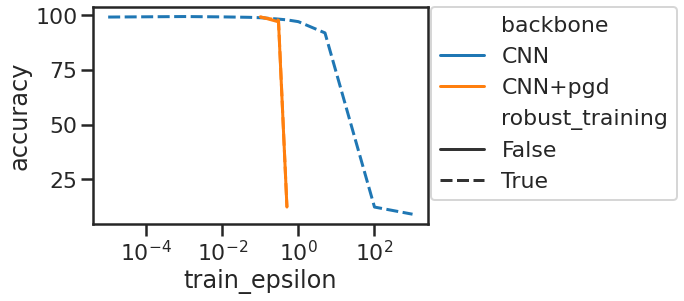

In [18]:
plt.figure()
sns.lineplot(x="train_epsilon", y="accuracy",
             hue="backbone",  style='robust_training', palette="tab10",
             data=df_results[(df_results.attack==name_attacks[0])])
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

[65, 66, 67, 68, 69]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


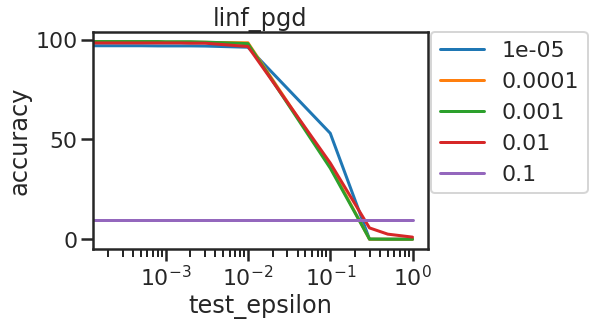

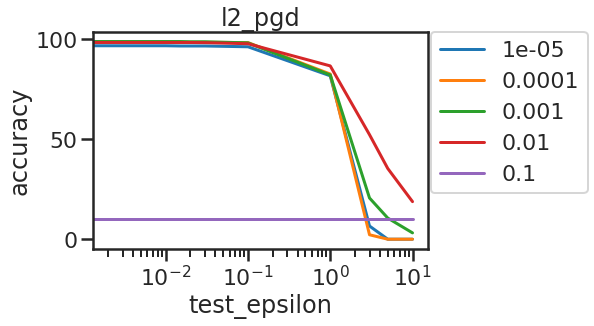

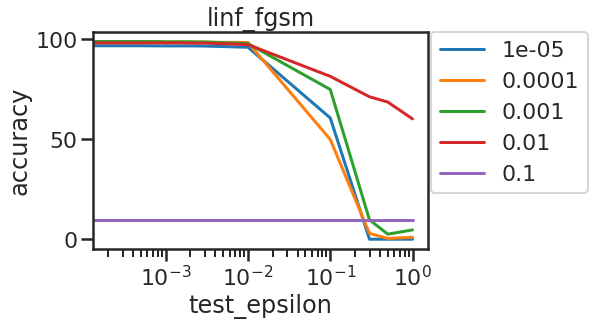

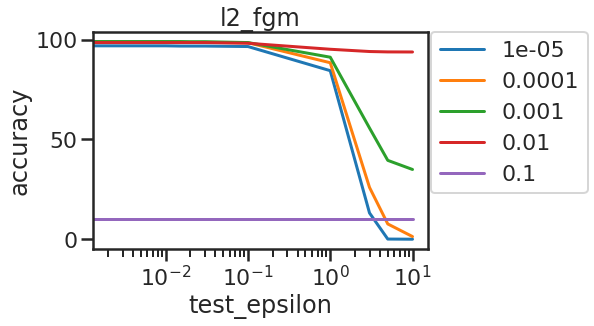

In [27]:
# Display learning rate impact
epsilon = 0.01
backbone = 'CNN'
robust_training = False
epsilon_pgd_training = 0.1

if robust_training:
    ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
               set(parameters["robust_training"][robust_training]) 
               & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
else:
    ids = list(set(parameters["backbone"][backbone]) &
            set(parameters["robust_training"][robust_training]) & 
               set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))

print(ids)
list_entries = []
for id in ids:
    entry = {"learning_rate": experiment_list[id]['initial_learning_rate'],
            "backbone": experiment_list[id]['backbone'],
            "robust_training": experiment_list[id]['robust_training'],
            "epsilon": experiment_list[id]['epsilon']}
 
    for dataset in ["val", "test"]:
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="learning_rate",  palette="tab10",
                 data=df[df.dataset=='val'][df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


In [7]:
df

,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy
0,0.10000,CNN,False,0.1,val,linf_pgd,0.0000,9.843750
1,0.10000,CNN,False,0.1,val,linf_pgd,0.0002,9.843750
2,0.10000,CNN,False,0.1,val,linf_pgd,0.0005,9.843750
3,0.10000,CNN,False,0.1,val,linf_pgd,0.0008,9.843750
4,0.10000,CNN,False,0.1,val,linf_pgd,0.0010,9.843750
...,...,...,...,...,...,...,...,...
515,0.00001,CNN,False,0.1,test,l2_fgm,0.1000,10.273438
516,0.00001,CNN,False,0.1,test,l2_fgm,1.0000,10.273438
517,0.00001,CNN,False,0.1,test,l2_fgm,3.0000,10.273438
518,0.00001,CNN,False,0.1,test,l2_fgm,5.0000,10.273438


255
258
261
264
267
270


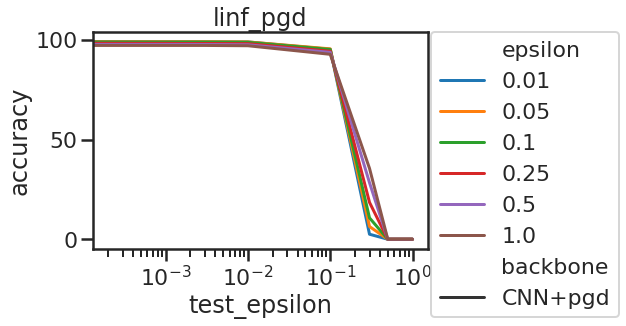

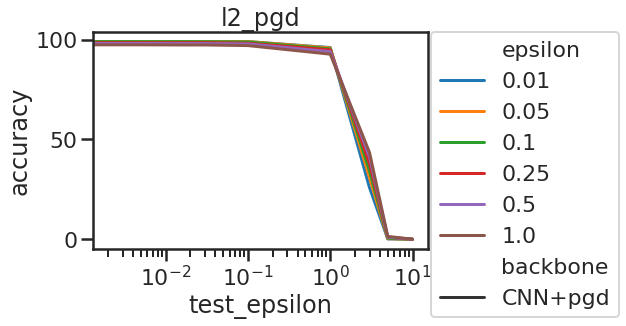

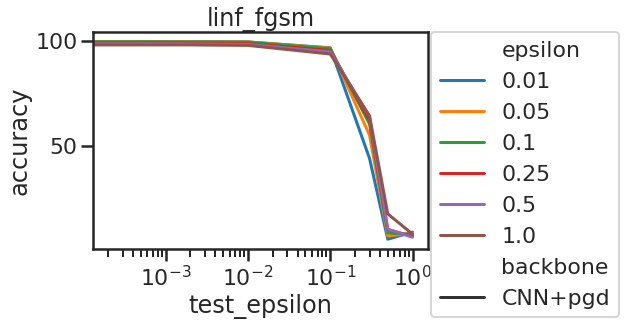

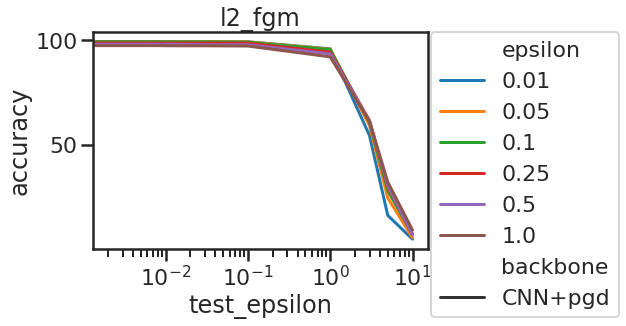

In [70]:
# Display epsilon
backbones = ['CNN+pgd']
robust_training = True
epsilon_pgd_training = 0.1

list_entries = []
for backbone in backbones:
    for epsilon in list(parameters["epsilon"].keys()):

            
        if robust_training:
            ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
                       set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
        else:
            ids = list(set(parameters["backbone"][backbone]) &
                    set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
            
        if len(ids)==0:
            continue
            
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in tmp.keys():
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc
                
        print(best_id)
        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="epsilon",  style='backbone', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


108
66
300


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


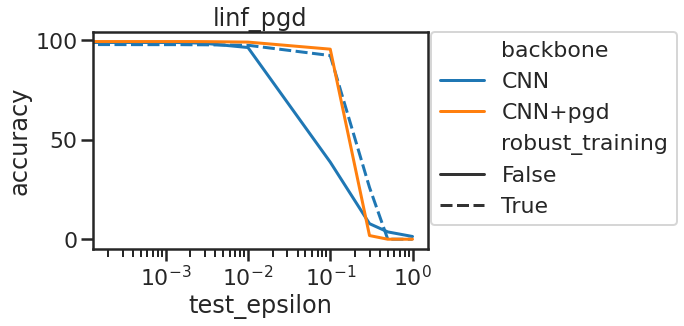

<Figure size 432x288 with 0 Axes>

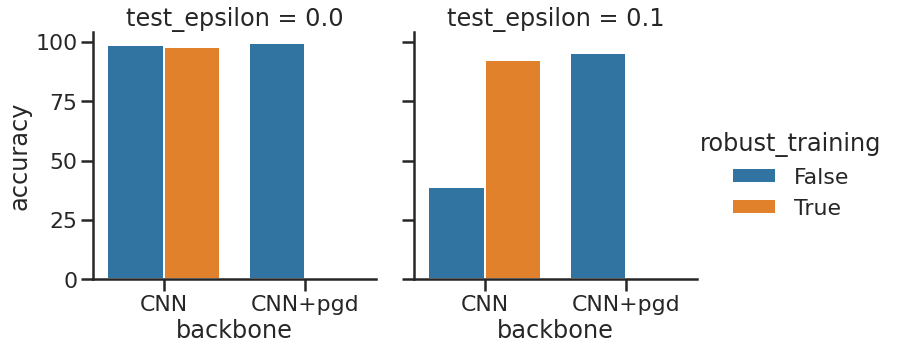

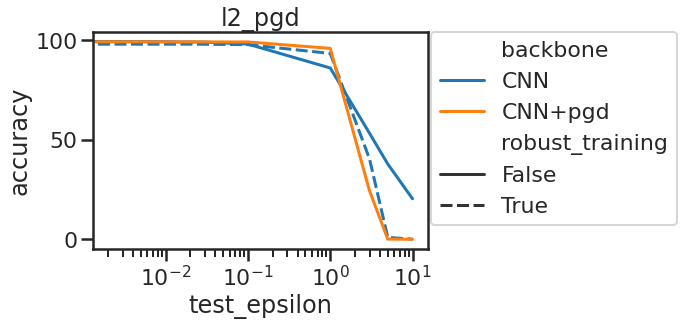

<Figure size 432x288 with 0 Axes>

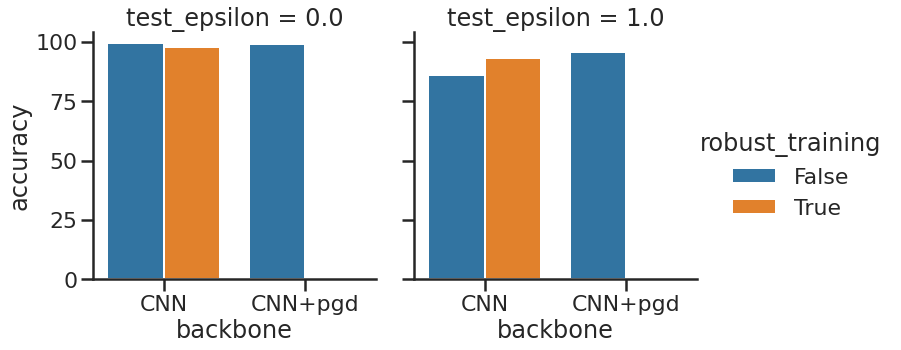

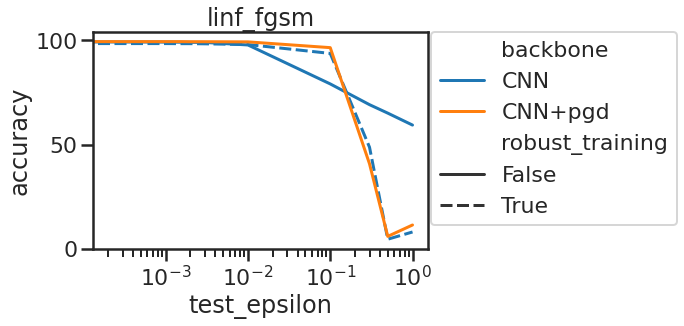

<Figure size 432x288 with 0 Axes>

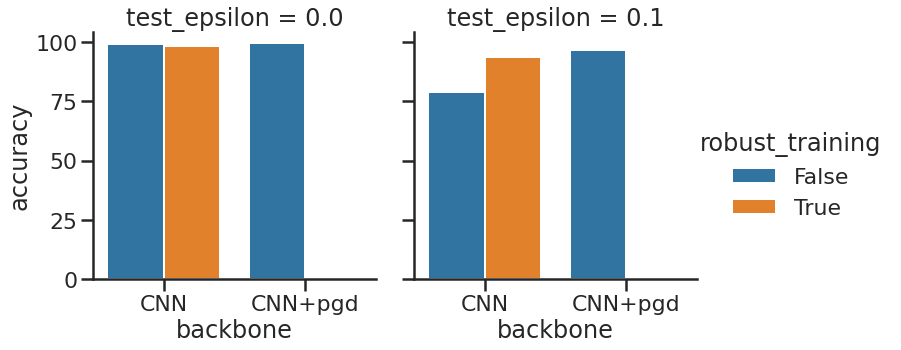

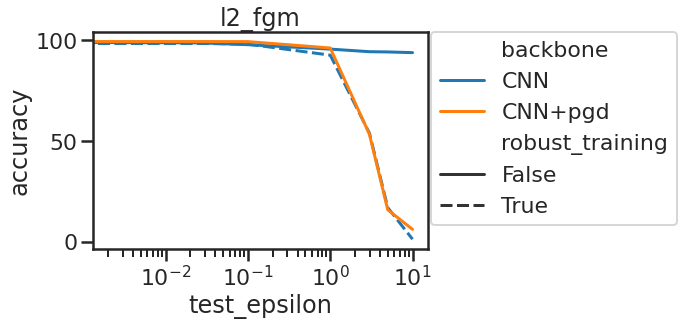

<Figure size 432x288 with 0 Axes>

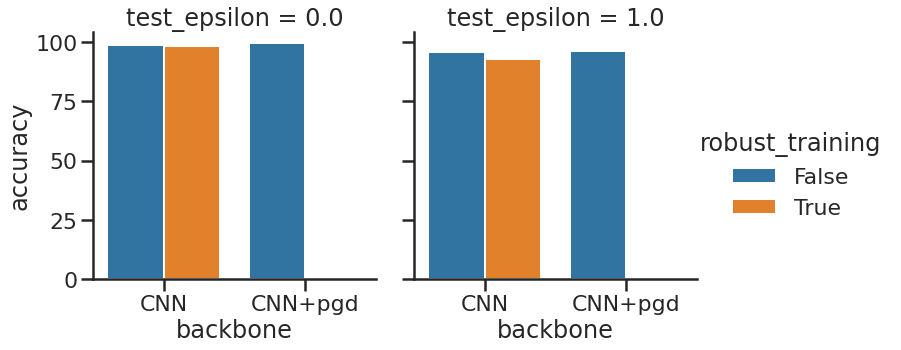

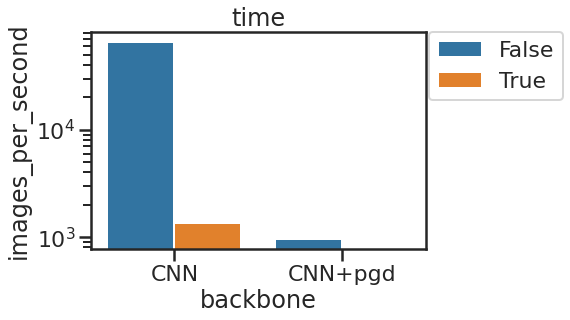

In [28]:
# Display best
backbones = ['CNN', "CNN+pgd"] #'Madry','MLP' 
robust_trainings = [True, False]

list_entries = []
for backbone in backbones:
    for robust_training in robust_trainings:
        if (backbone == 'Madry' and robust_training == True) or \
            (backbone == 'CNN+clipping' and robust_training == False):
            continue
            
        if backbone == 'CNN+pgd' and robust_training == True:
            continue
            
        ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))

        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            if (experiment_list[id]['backbone'] == 'CNN+pgd') and experiment_list[id]["epsilon_pgd_training"] == 0.3:
                continue 
            acc = 0.0
            for attack in [name_attacks[0]]:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        print(best_id)
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            
            if not backbone == 'Madry':
                with open(results_dir + experiment_list[best_id]['model_name'] + 
                          '/results/training_time.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                entry["images_per_second"] = np.mean(tmp) 
                entry["std_images_per_second"] = np.std(tmp) 
                
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
            

                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    plt.figure()
    epsilon = 0.1
    if attack == "l2_pgd" or attack == "l2_fgm" :
        epsilon = 1
    sns.catplot(x="backbone", y="accuracy",
                 hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                 data=df[(df.test_epsilon == 0)| (df.test_epsilon == epsilon)][df.attack==attack])
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [14]:
experiment_list[179]

{'_comment': '=====ADVERSARIAL EXAMPLES CONFIGURATION=====',
 'model_name': '179',
 'restart': False,
 'data_set': 0,
 'backbone': 'CNN+pgd',
 'l1_size': 200,
 'l2_size': 200,
 'random_seed': 4557077,
 'robust_training': False,
 'clipping_training': False,
 'max_num_training_steps': 10000,
 'num_output_steps': 500,
 'training_size': 50000,
 'training_batch_size': 256,
 'initial_learning_rate': 0.0001,
 'batch_decrease_learning_rate': 5,
 'eval_attack_during_training': False,
 'epsilon': 1,
 'increasing_epsilon': False,
 'bound_upper': 10000000000.0,
 'bound_lower': -10000000000.0,
 'standarize': True,
 'standarize_multiplier': 128,
 'pgd_training': True,
 'epsilon_pgd_training': 0.5}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
218,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN
270,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN


In [107]:
df[df.backbone=="Madry"][df.attack=="linf_fgsm"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
244,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
296,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
